In [3]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import SQcircuit as sq
import qutip as qt
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import importlib
from IPython.display import HTML

%matplotlib ipympl
plt.rcParams['text.usetex'] = False
importlib.reload(sq_ext)
importlib.reload(sq)
importlib.reload(figs)
np.set_printoptions(linewidth=200, formatter={'float': '{:.1e}'.format})

# Study of the properties of the qubit vs inductance asymmetry (Δ) and external flux (φ_ext)

In [10]:
# Fundamental constants
h    = 6.62607015e-34
GHz = 1e9
e0   = 1.602176634e-19
Φ_0 = h/(2*e0)

## KIT's qubit

This notebook studies the qubit proposed by KIT. It's lumped element model is:
<img src='Other/Single qubit 4 nodes CC coupled to ground.jpg' width='500'>


In [13]:
# Circuit parameters
Csh = 15
C   = 15
Cg  = 10
CJ  = 3
Lq  = 25
Lr  = 10
Δ   = 0.1
EJ  = 10.0
l = Lq*(Lq+4*Lr) - 4*Δ**2

E_J = EJ * 1e9
L_r = l/Lq * 1e-9
E_L_r = (Φ_0/(2*np.pi))**2/L_r / h

## Circuit definitions

In [12]:
Δ_values = np.concatenate( (np.geomspace(1e-5,1e-1, 20), np.linspace(1e-1,10,10) ))
qubit = sq_ext.KIT_qubit()
qubit_vs_Δ = [ sq_ext.KIT_qubit(Δ=Δ) for Δ in Δ_values]
resonator_vs_Δ = [ sq_ext.KIT_resonator(Δ=Δ) for Δ in Δ_values]
fluxonium_vs_Δ = [ sq_ext.KIT_fluxonium(Δ=Δ) for Δ in Δ_values]

trunc_nums = [1, 15, 15]
trunc_nums_resonator = [15]
trunc_nums_fluxonium = [15]
trunc_nums_Δ_0 = [ 15, 15]

for i in range(len(qubit_vs_Δ)):
    resonator_vs_Δ[i].set_trunc_nums(trunc_nums_resonator)
    fluxonium_vs_Δ[i].set_trunc_nums(trunc_nums_fluxonium)
    try:
        qubit_vs_Δ[i].set_trunc_nums(trunc_nums)
    except:
        qubit_vs_Δ[i].set_trunc_nums(trunc_nums_Δ_0)

# Spectrum 

In [7]:
circuit = qubit_vs_Δ[-1]
circuit = qubit
n_eig = 8
circuit.set_trunc_nums([1, 5, 10])
phi = np.linspace(0,0.5,100)

E_circuit = np.zeros((n_eig, len(phi)))

for i in range(len(phi)):
    circuit.loops[0].set_flux(phi[i])
    E_circuit[:, i] = circuit.diag(n_eig)[0]

In [8]:
φ_ext_avoided_crossing = 0.372
φext_values = [0, 0.372, 0.5]

E_vs_Δ_φext = np.zeros([len(φext_values), len(Δ_values),  n_eig])

for i, φext in enumerate(φext_values):
    for j, qubit_Δ in enumerate(qubit_vs_Δ):
        qubit_Δ.loops[0].set_flux(φext)
        E_vs_Δ_φext[i, j , :] = qubit_Δ.diag(n_eig)[0]


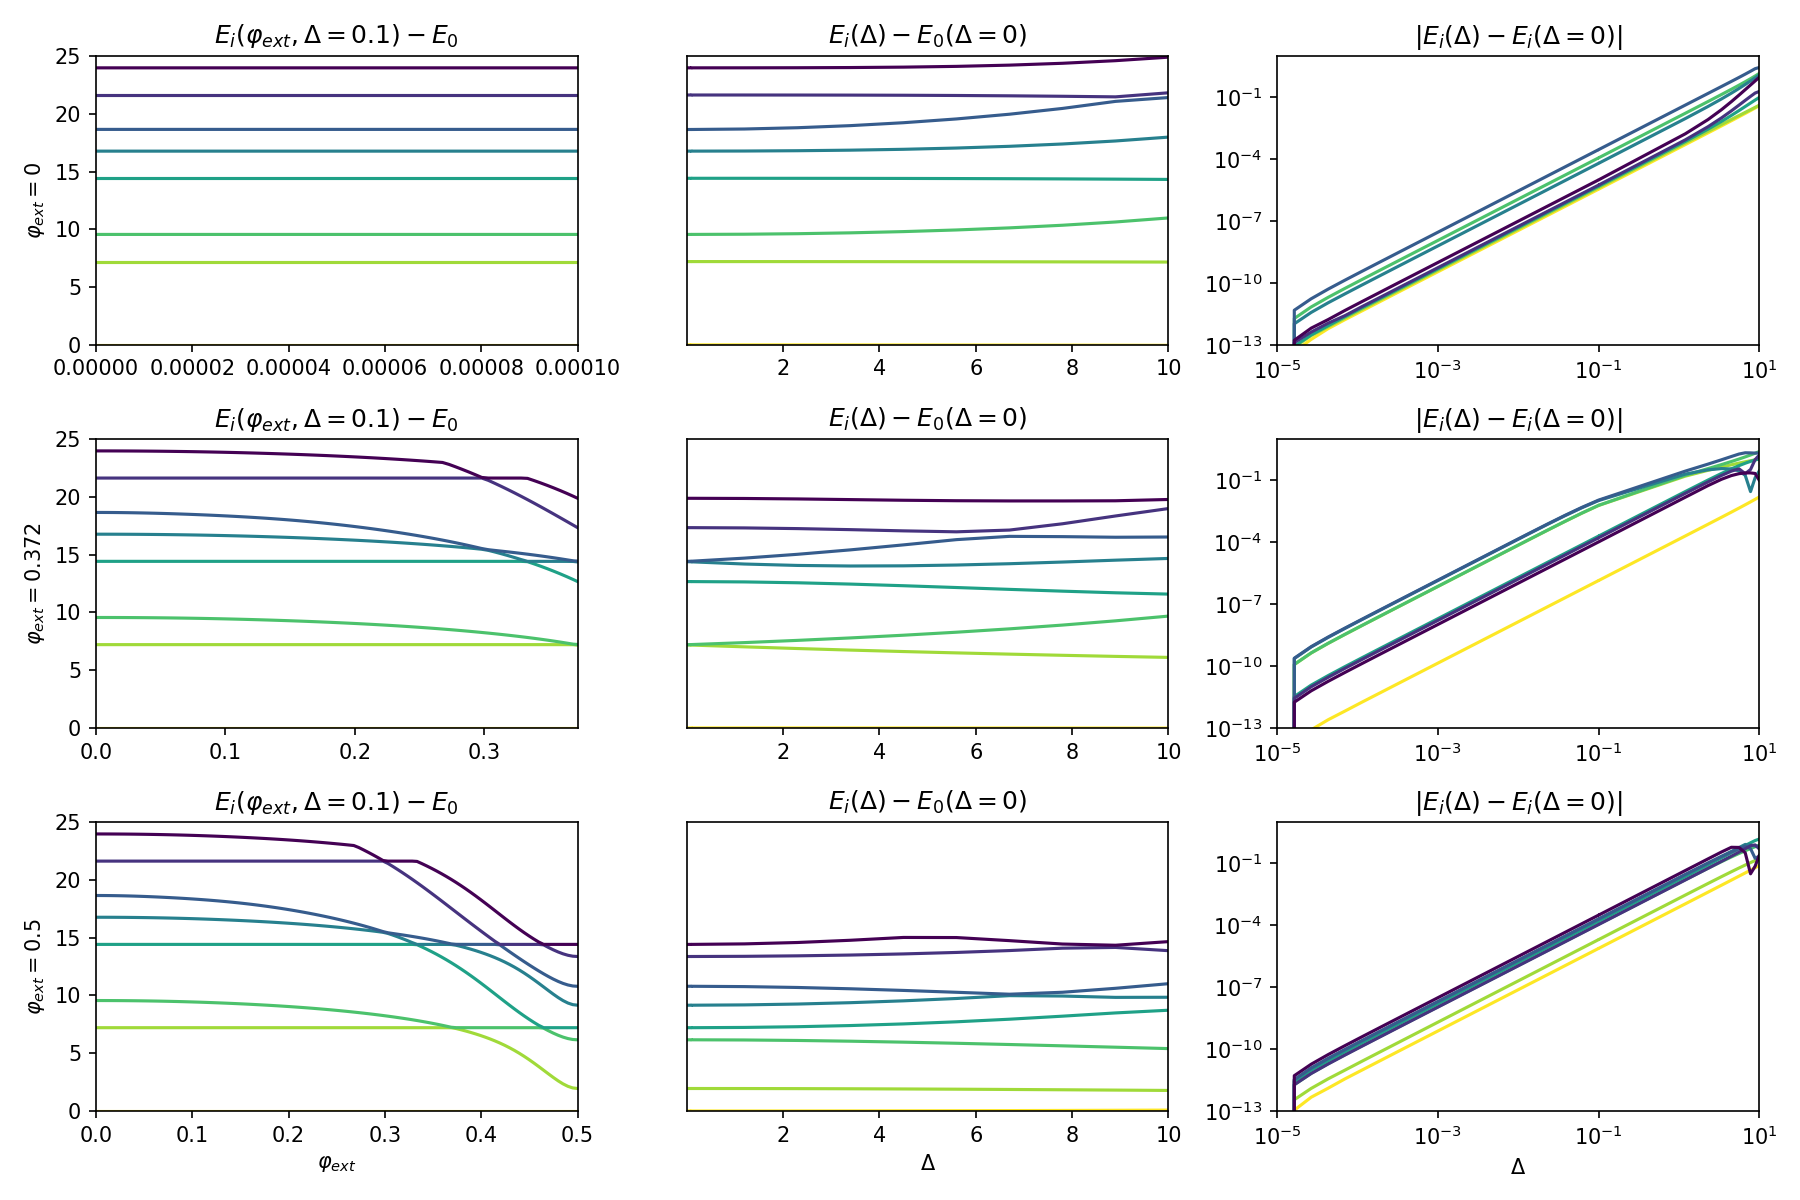

In [9]:
fig, axs = plt.subplots(nrows= 3, ncols = 3, figsize=[12,8], dpi=150)
eig_colors = plt.get_cmap('viridis_r')(np.linspace(0, 255, n_eig).astype('int'))

for i in range(n_eig):
    [axs[j,0].plot(phi, E_circuit[i,:]- E_circuit[0,:], color=eig_colors[i]) for j in range(len(φext_values)) ]

[axs[i,0].set_ylim([0,25]) for i in range(len(φext_values))]
[axs[i,0].set_title(r"$E_i(\varphi_{ext}, \Delta=0.1)-E_0$") for i in range(len(φext_values))]
[axs[i,0].set_ylabel(r'$ \varphi_{ext}=$' + f'{φext_values[i]}' ) for i in range(len(φext_values))]
axs[2,0].set_xlabel(r'$\varphi_{ext}$')

for i, φext in enumerate(φext_values):
    axs[i,0].set_xlim([0, φext+0.0001])
    for j in range(n_eig):
        axs[i,1].plot(Δ_values, E_vs_Δ_φext[i, :, j]- E_vs_Δ_φext[i, 0, 0], color=eig_colors[j])
        axs[i,2].plot(Δ_values, np.abs(E_vs_Δ_φext[i, :, j]- E_vs_Δ_φext[i, 0, j]), color=eig_colors[j])

    axs[i,1].margins(0)
    axs[i,1].set_ylim([0,25])
    axs[i,1].set_yticks([])
    axs[i,1].set_title(r'$E_i(\Delta)-E_0(\Delta=0)$')
    # axs[i,1].set_xscale('log')
    axs[i,2].set_title(r'$|E_i(\Delta)-E_i(\Delta=0)|$')
    axs[i,2].set_xscale('log')
    axs[i,2].set_yscale('log')
    axs[i,2].margins(0)
    axs[i,2].set_ylim([1e-13, 1e1])

axs[2,1].set_xlabel(r'$\Delta$')
axs[2,2].set_xlabel(r'$\Delta$')

fig.tight_layout()
fig.show()

## Wavefunctions

In [14]:
φ_ext = φ_ext_avoided_crossing

φ_r = np.linspace(-3,3,200)
φ_f = np.linspace(-3, 3, 200)

φ_2 = np.linspace(-.03, .03, 100)/2/np.pi
φ_3 = np.linspace(-3, 3 , 100)/2/np.pi
grid_q = [0, φ_2, φ_3]

Ψ_r_0_vs_Δ = []
Ψ_r_1_vs_Δ = []
Ψ_f_0_vs_Δ = []
Ψ_f_1_vs_Δ = []
V_f_vs_Δ = []
Ψ_q_0_vs_Δ = []
Ψ_q_1_vs_Δ = []

for resonator_Δ, fluxonium_Δ, qubit_Δ, Δ in zip(resonator_vs_Δ, fluxonium_vs_Δ, qubit_vs_Δ, Δ_values):
    fluxonium_Δ.loops[0].set_flux(φ_ext)
    qubit_Δ.loops[0].set_flux(φ_ext)
    
    _, _ = resonator_Δ.diag(2)
    Ψ_r_0_vs_Δ.append( np.abs(resonator_Δ.eig_phase_coord(k=0, grid=[φ_r/2/np.pi]))**2 )
    Ψ_r_1_vs_Δ.append( np.abs(resonator_Δ.eig_phase_coord(k=1, grid=[φ_r/2/np.pi]))**2 )
    
    V_r = 0.5 * E_L_r * φ_r **2
    
    _, _ = fluxonium_Δ.diag(2)
    Ψ_f_0_vs_Δ.append( np.abs(fluxonium_Δ.eig_phase_coord(k=0, grid=[φ_f/2/np.pi]))**2 )
    Ψ_f_1_vs_Δ.append( np.abs(fluxonium_Δ.eig_phase_coord(k=1, grid=[φ_f/2/np.pi]))**2 )
    
    l_Δ = Lq*(Lq+4*Lr) - 4*Δ**2
    L_q = l_Δ / (Lq + 4 * Lr) * 1e-9
    E_L_f = (Φ_0 / (2 * np.pi)) ** 2 / L_q / h
    V_f_Δ = 0.5 * E_L_f * (φ_f) ** 2 - E_J * np.cos(φ_f - φ_ext * 2 * np.pi) 
    V_f_vs_Δ.append( (V_f_Δ-V_f_Δ.min())/1e9 )
    
    _, _ = qubit_Δ.diag(2)
    Ψ_q_0_vs_Δ.append( np.abs(qubit_Δ.eig_phase_coord(k=0, grid=grid_q).T)**2 )
    Ψ_q_1_vs_Δ.append( np.abs(qubit_Δ.eig_phase_coord(k=1, grid=grid_q).T)**2 )


In [60]:
fig, axs = plt.subplots(ncols=2)
                       
axs[0].plot(φ_r, (V_r-V_r.min())/1e9, 'k:')
Ψ_r_0_plot, = axs[0].plot(φ_r, Ψ_r_0_vs_Δ[0], label=r'$\psi_R^0$')
Ψ_r_1_plot, = axs[0].plot(φ_r, Ψ_r_1_vs_Δ[0], label=r'$\psi_R^1$')
axs[0].set_xlabel(r'$\varphi_R$')
axs[0].set_ylim([-.1,3])

V_f_plot, =   axs[1].plot(φ_f, V_f_vs_Δ[0] , 'k:')
Ψ_f_0_plot, = axs[1].plot(φ_f, Ψ_f_0_vs_Δ[0], label=r'$\psi_F^0$')
Ψ_f_1_plot, = axs[1].plot(φ_f, Ψ_f_1_vs_Δ[0], label=r'$\psi_F^1$')
axs[1].set_xlabel(r'$\varphi_F$')
axs[1].set_ylim([-.1,4])

ani = figs.animation(fig, [Ψ_r_0_plot, Ψ_r_1_plot, Ψ_f_0_plot, Ψ_f_1_plot, V_f_plot], 
                          [Ψ_r_0_vs_Δ, Ψ_r_1_vs_Δ, Ψ_f_0_vs_Δ, Ψ_f_1_vs_Δ, V_f_vs_Δ],
                           r'$\Delta=$', Δ_values)
 
HTML(ani.to_jshtml())

In [61]:
fig, axs = plt.subplots(ncols=2)
                       
Ψ_q_0_plot = axs[0].contourf(φ_3, φ_2, Ψ_q_0_vs_Δ[0], cmap="Blues")
axs[0]. set_ylabel(r'$\tilde{\varphi}_R$')
axs[0]. set_xlabel(r'$\tilde{\varphi}_F$')
axs[0].text(.9,.9, r'$\psi^0$', transform=axs[0].transAxes, ha="center", va="center")

Ψ_q_1_plot = axs[1].contourf(φ_3, φ_2, Ψ_q_1_vs_Δ[1], cmap="Oranges")
axs[1]. set_ylabel(r'$\tilde{\varphi}_R$')
axs[1]. set_xlabel(r'$\tilde{\varphi}_F$')
axs[1].text(.9,.9, r'$\psi^1$', transform=axs[1].transAxes, ha="center", va="center")

ani = figs.animation_contour(fig, [Ψ_q_0_plot, Ψ_q_1_plot ],
                                   φ_3, φ_2, 
                                  [Ψ_q_0_vs_Δ, Ψ_q_1_vs_Δ],
                                   r'$\Delta=$', Δ_values)
 
HTML(ani.to_jshtml())

# Fluxonium-Resonator internal coupling


### Approach 1: Numerical evaluation of the coupling that has been deduced from the Hamiltonian.

In [65]:
qubit.set_trunc_nums([1, 15, 15])
resonator.set_trunc_nums([15])
fluxonium.set_trunc_nums([15])

loop.set_flux(0.5)
loop_fluxonium.set_flux(0.5)
# loop_fluxonium.set_flux(0.371)

_ = qubit.diag(2)
_ = fluxonium.diag(2)
_ = resonator.diag(2)

In [36]:
g = Φ_r * Φ_f / L_c / GHz  #/ 2 /np.pi
print(g)

0.09070912782598381


In [37]:
g / Δ01 * 100

4.662844610492564

### Approach 2: Analytical approximation of the coupling that has been deduced from the Hamiltonian.

In [38]:
dVdφ =  lambda φ: E_L_f*φ + E_J*np.sin(φ+np.pi)
φ_min = sp.optimize.fsolve(dVdφ, 1)[0]
φ_min

1.5279722082410827

In [39]:
Φ_f_an =(Φ_0 / (2*np.pi)) * φ_min / np.sqrt(sq.hbar)
Φ_f_an

48.968088326233854

In [40]:
# This should be the same as that calculated numerically
Φ_r_an = np.sqrt(1/2 * np.sqrt(L_r/C_r))
Φ_r_an

38.36589667717856

In [41]:
g_an = Φ_f_an * Φ_r_an /L_c  /GHz
g_an

0.11561543774635939

In [42]:
g_an / Δ01 * 100

5.94313751775403

### Approach 3: Extract the coupling by applying the SWT to project the qubit onto the qubit without interaction (Delta=0)

In [43]:
circ_0 = qubit_vs_Δ[0]
circ = qubit
circ = qubit

# circ.loops[0].set_flux(0.372)
# circ_0.loops[0].set_flux(0.372)
circ.loops[0].set_flux(0.5)
circ_0.loops[0].set_flux(0.5)

n_eig = 4
try:
    circ_0.set_trunc_nums([15,15])
except:
    circ_0.set_trunc_nums([1, 15,15])
circ.set_trunc_nums([1,15,15])

_ = circ_0.diag(n_eig)
_ = circ.diag(n_eig)


In [44]:
H_eff = sq_ext.H_eff_SWT_circuit(circ_0, circ_0) / GHz
P = sq_ext.decomposition_in_pauli_2x2(H_eff[:2,:2])
E0 = P[0]
Δ_01 = P[-1] * 2
E0, Δ_01

(7.679646285106777, -1.9453880907018215)

In [45]:
H_eff = sq_ext.H_eff_SWT_circuit(circ_0, circ_0) / GHz - E0*np.eye(len(H_eff))
print(np.round(H_eff, 3))

[[-0.973-0.j  0.   -0.j -0.   -0.j  0.   +0.j]
 [ 0.   +0.j  0.973+0.j  0.   +0.j -0.   +0.j]
 [-0.   +0.j  0.   -0.j  5.189+0.j  0.   -0.j]
 [ 0.   -0.j -0.   -0.j  0.   +0.j  6.236-0.j]]


In [46]:
H_eff = sq_ext.H_eff_SWT_circuit(circ_0, circ) / GHz  - E0*np.eye(len(H_eff))
print(np.round(H_eff, 3))

[[-0.973+0.j  0.   -0.j  0.   +0.j -0.   -0.j]
 [ 0.   +0.j  0.974-0.j -0.   -0.j  0.085+0.j]
 [ 0.   -0.j -0.   +0.j  5.188-0.j -0.   +0.j]
 [-0.   +0.j  0.085-0.j -0.   -0.j  6.234+0.j]]


In [47]:
g = [ (sq_ext.H_eff_SWT_circuit(circ_0, circ) / GHz - E0*np.eye(len(H_eff)))[1,1] for circ in qubit_vs_Δ]


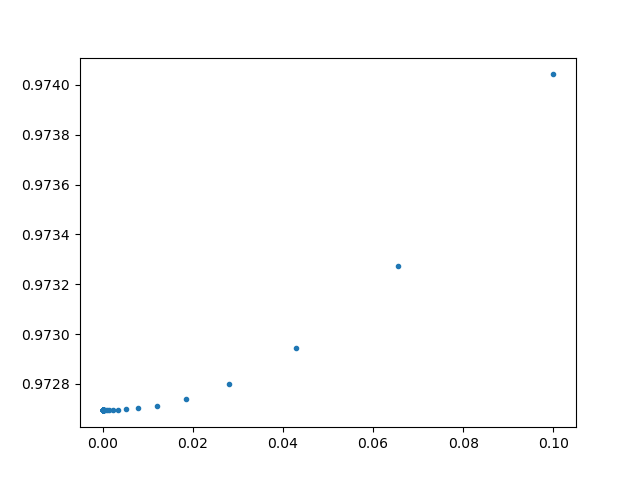

In [48]:
fig, ax = plt.subplots()
ax.plot(Δ_values, np.abs(np.array(g)), '.')
fig.show()

In [49]:
np.abs(H_eff[0,2])

0.00013140984189002092

In [50]:
np.abs(H_eff[1,3])

0.08484002790140274

In [51]:
H_eff_p1 = sq_ext.H_eff_p1(circ_0, circ)/ GHz - E0*np.eye(len(H_eff))
print(np.round(H_eff_p1, 3))


[[-9.720e-01+0.j  0.000e+00-0.j  1.000e-03+0.j -0.000e+00-0.j]
 [ 0.000e+00+0.j  9.740e-01+0.j -0.000e+00-0.j  8.500e-02+0.j]
 [ 1.000e-03-0.j -0.000e+00+0.j  5.190e+00-0.j -0.000e+00+0.j]
 [-0.000e+00+0.j  8.500e-02-0.j -0.000e+00-0.j  6.236e+00+0.j]]


#